# Vehicle Detection using Single Shot Multibox Detector (SSD)

In [200]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline

classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']

## Model loading and setup

Training the model requires GPUs and is very time consuming. Here I load pre-trained weights downloaded from https://github.com/rykov8/ssd_keras and also define a bounding box utility to help decode the outputs.

In [201]:
model = SSD300((300, 300, 3), num_classes=len(classes)+1)
model.load_weights('weights_SSD300.hdf5')
bbox_util = BBoxUtility(len(classes)+1)

## Pipeline definition

The pipeline consists of two main functions. The loaded image/frame gets passed to the process_frame function and then some preprocessing is done on it. After that, we predict the output using the model we loaded above, and then we decode the output using the bounding box utility.
After that, further decoding is done on the output to find the highest probability that this box refers to a car. I used a threshold of 0.6.

In [202]:
def decode_output(out, thresh=0.6):
    out_label  = out[0][:,0]
    conf_score = out[0][:,1]
    x1         = out[0][:,2]
    y1         = out[0][:,3]
    x2         = out[0][:,4]
    y2         = out[0][:,5]
    
    indices = []
    for i in range(len(conf_score)):
        if conf_score[i] >= thresh and out_label[i] == 7:
            indices.append(i)
    
    return conf_score[indices], out_label[indices].tolist(), x1[indices], y1[indices], x2[indices], y2[indices]

def process_frame(img):
    img_pr = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
    inputs = preprocess_input(np.array([image.img_to_array(img_pr).copy()]))
    
    preds = model.predict(inputs, batch_size=1, verbose=0)
    out = bbox_util.detection_out(preds)
    
    conf, labels, x1, y1, x2, y2 = decode_output(out, 0.6)

    for i in range(len(conf)):
        xmin = int(round(x1[i] * img.shape[1]))
        ymin = int(round(y1[i] * img.shape[0]))
        xmax = int(round(x2[i] * img.shape[1]))
        ymax = int(round(y2[i] * img.shape[0]))
        score=conf[i]
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
        cv2.putText(img, str(round(score*100, 2))+'%', (xmin,ymin-6), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,0,0),2,cv2.LINE_AA)
    
    return img

## Testing the pipeline on a random test image

In this part, I load all the test images from the test_images folder, and I choose a random image and run the pipeline on it. Every time this part of the code is run, a new image is going to be loaded.

(720, 1280, 3)


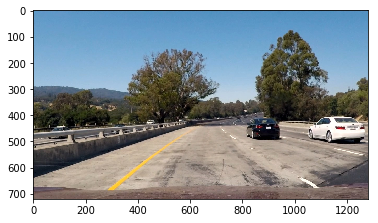

In [203]:
files = glob.glob("./test_images/*.jpg")
idx = np.random.randint(0,len(files))
img = cv2.imread(files[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)

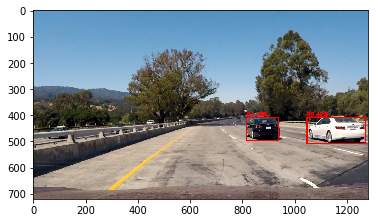

In [204]:
out_img = process_frame(img)
plt.imshow(out_img)

## Loading video files and processing them

Here we load all the video files from the directory and run the pipeline on them.

In [189]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vids = glob.glob("./*.mp4")
for i in range(len(vids)):
    out_name = vids[i][2:-4] + '_processed.mp4'
    clip = VideoFileClip(vids[i])
    white_clip = clip.fl_image(process_frame)
    %time white_clip.write_videofile(out_name, audio=False)

[MoviePy] >>>> Building video project_video_file_processed.mp4
[MoviePy] Writing video project_video_file_processed.mp4





  0%|          | 0/39 [00:00<?, ?it/s]


  3%|▎         | 1/39 [00:01<00:59,  1.58s/it]


  5%|▌         | 2/39 [00:03<00:58,  1.58s/it]


  8%|▊         | 3/39 [00:04<00:57,  1.59s/it]


 10%|█         | 4/39 [00:06<00:55,  1.59s/it]


 13%|█▎        | 5/39 [00:08<00:54,  1.61s/it]


 15%|█▌        | 6/39 [00:09<00:53,  1.62s/it]


 18%|█▊        | 7/39 [00:11<00:52,  1.63s/it]


 21%|██        | 8/39 [00:13<00:50,  1.64s/it]


 23%|██▎       | 9/39 [00:14<00:49,  1.64s/it]


 26%|██▌       | 10/39 [00:16<00:48,  1.66s/it]


 28%|██▊       | 11/39 [00:18<00:46,  1.66s/it]


 31%|███       | 12/39 [00:19<00:44,  1.66s/it]


 33%|███▎      | 13/39 [00:21<00:42,  1.65s/it]


 36%|███▌      | 14/39 [00:23<00:41,  1.65s/it]


 38%|███▊      | 15/39 [00:24<00:39,  1.65s/it]


 41%|████      | 16/39 [00:26<00:37,  1.65s/it]


 44%|████▎     | 17/39 [00:27<00:36,  1.65s/it]


 46%|████▌     | 18/39 [00:29<00:34,  1.64s/it]


 49%|████▊     | 19/39 [00:31<00:32,  1.64s/it]


 51%|█████▏    

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_file_processed.mp4 

CPU times: user 2min 58s, sys: 10.1 s, total: 3min 8s
Wall time: 1min 4s
[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:01<35:30,  1.69s/it]


  0%|          | 2/1261 [00:03<35:45,  1.70s/it]


  0%|          | 3/1261 [00:05<35:38,  1.70s/it]


  0%|          | 4/1261 [00:07<36:55,  1.76s/it]


  0%|          | 5/1261 [00:09<39:02,  1.86s/it]


  0%|          | 6/1261 [00:11<39:33,  1.89s/it]


  1%|          | 7/1261 [00:13<39:12,  1.88s/it]


  1%|          | 8/1261 [00:14<38:55,  1.86s/it]


  1%|          | 9/1261 [00:16<38:44,  1.86s/it]


  1%|          | 10/1261 [00:18<38:49,  1.86s/it]


  1%|          | 11/1261 [00:20<38:22,  1.84s/it]


  1%|          | 12/1261 [00:21<37:57,  1.82s/it]


  1%|          | 13/1261 [00:23<37:42,  1.81s/it]


  1%|          | 14/1261 [00:25<37:26,  1.80s/it]


  1%|          | 15/1261 [00:26<37:09,  1.79s/it]


  1%|▏         | 16/1261 [00:28<37:01,  1.78s/it]


  1%|▏         | 17/1261 [00:30<36:50,  1.78s/it]


  1%|▏         | 18/1261 [00:31<36:47,  1.78s/it]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [04:01<33:47,  1.80s/it]


 11%|█         | 135/1261 [04:02<33:45,  1.80s/it]


 11%|█         | 136/1261 [04:04<33:44,  1.80s/it]


 11%|█         | 137/1261 [04:06<33:42,  1.80s/it]


 11%|█         | 138/1261 [04:08<33:39,  1.80s/it]


 11%|█         | 139/1261 [04:09<33:37,  1.80s/it]


 11%|█         | 140/1261 [04:11<33:34,  1.80s/it]


 11%|█         | 141/1261 [04:13<33:31,  1.80s/it]


 11%|█▏        | 142/1261 [04:15<33:30,  1.80s/it]


 11%|█▏        | 143/1261 [04:16<33:28,  1.80s/it]


 11%|█▏        | 144/1261 [04:19<33:30,  1.80s/it]


 11%|█▏        | 145/1261 [04:21<33:28,  1.80s/it]


 12%|█▏        | 146/1261 [04:22<33:26,  1.80s/it]


 12%|█▏        | 147/1261 [04:24<33:24,  1.80s/it]


 12%|█▏        | 148/1261 [04:26<33:23,  1.80s/it]


 12%|█▏        | 149/1261 [04:28<33:25,  1.80s/it]


 12%|█▏        | 150/1261 [04:31<33:27,  1.81s/it]


 12%|█▏        | 151/1261 [04:33<33:28,  1.81s/it]


 12%|█▏        | 152/1261 [04:35<33:28,  1.81s

 21%|██        | 266/1261 [08:27<31:36,  1.91s/it]


 21%|██        | 267/1261 [08:28<31:34,  1.91s/it]


 21%|██▏       | 268/1261 [08:30<31:31,  1.91s/it]


 21%|██▏       | 269/1261 [08:32<31:29,  1.90s/it]


 21%|██▏       | 270/1261 [08:34<31:26,  1.90s/it]


 21%|██▏       | 271/1261 [08:35<31:24,  1.90s/it]


 22%|██▏       | 272/1261 [08:37<31:22,  1.90s/it]


 22%|██▏       | 273/1261 [08:39<31:20,  1.90s/it]


 22%|██▏       | 274/1261 [08:41<31:18,  1.90s/it]


 22%|██▏       | 275/1261 [08:43<31:17,  1.90s/it]


 22%|██▏       | 276/1261 [08:45<31:15,  1.90s/it]


 22%|██▏       | 277/1261 [08:47<31:14,  1.90s/it]


 22%|██▏       | 278/1261 [08:49<31:11,  1.90s/it]


 22%|██▏       | 279/1261 [08:51<31:09,  1.90s/it]


 22%|██▏       | 280/1261 [08:52<31:07,  1.90s/it]


 22%|██▏       | 281/1261 [08:54<31:04,  1.90s/it]


 22%|██▏       | 282/1261 [08:56<31:01,  1.90s/it]


 22%|██▏       | 283/1261 [08:58<30:59,  1.90s/it]


 23%|██▎       | 284/1261 [08:59<30:56,  1.90s

 32%|███▏      | 398/1261 [12:31<27:08,  1.89s/it]


 32%|███▏      | 399/1261 [12:32<27:06,  1.89s/it]


 32%|███▏      | 400/1261 [12:34<27:04,  1.89s/it]


 32%|███▏      | 401/1261 [12:36<27:02,  1.89s/it]


 32%|███▏      | 402/1261 [12:38<27:00,  1.89s/it]


 32%|███▏      | 403/1261 [12:40<26:58,  1.89s/it]


 32%|███▏      | 404/1261 [12:41<26:56,  1.89s/it]


 32%|███▏      | 405/1261 [12:43<26:53,  1.89s/it]


 32%|███▏      | 406/1261 [12:45<26:51,  1.89s/it]


 32%|███▏      | 407/1261 [12:47<26:49,  1.88s/it]


 32%|███▏      | 408/1261 [12:48<26:47,  1.88s/it]


 32%|███▏      | 409/1261 [12:50<26:45,  1.88s/it]


 33%|███▎      | 410/1261 [12:52<26:43,  1.88s/it]


 33%|███▎      | 411/1261 [12:54<26:41,  1.88s/it]


 33%|███▎      | 412/1261 [12:55<26:39,  1.88s/it]


 33%|███▎      | 413/1261 [12:57<26:36,  1.88s/it]


 33%|███▎      | 414/1261 [12:59<26:34,  1.88s/it]


 33%|███▎      | 415/1261 [13:01<26:32,  1.88s/it]


 33%|███▎      | 416/1261 [13:03<26:30,  1.88s

 42%|████▏     | 530/1261 [16:23<22:36,  1.86s/it]


 42%|████▏     | 531/1261 [16:25<22:34,  1.86s/it]


 42%|████▏     | 532/1261 [16:27<22:32,  1.86s/it]


 42%|████▏     | 533/1261 [16:28<22:30,  1.86s/it]


 42%|████▏     | 534/1261 [16:30<22:28,  1.86s/it]


 42%|████▏     | 535/1261 [16:32<22:26,  1.85s/it]


 43%|████▎     | 536/1261 [16:34<22:24,  1.85s/it]


 43%|████▎     | 537/1261 [16:35<22:22,  1.85s/it]


 43%|████▎     | 538/1261 [16:37<22:20,  1.85s/it]


 43%|████▎     | 539/1261 [16:39<22:18,  1.85s/it]


 43%|████▎     | 540/1261 [16:40<22:16,  1.85s/it]


 43%|████▎     | 541/1261 [16:42<22:14,  1.85s/it]


 43%|████▎     | 542/1261 [16:44<22:12,  1.85s/it]


 43%|████▎     | 543/1261 [16:46<22:10,  1.85s/it]


 43%|████▎     | 544/1261 [16:48<22:08,  1.85s/it]


 43%|████▎     | 545/1261 [16:49<22:06,  1.85s/it]


 43%|████▎     | 546/1261 [16:51<22:04,  1.85s/it]


 43%|████▎     | 547/1261 [16:53<22:02,  1.85s/it]


 43%|████▎     | 548/1261 [16:55<22:00,  1.85s

 52%|█████▏    | 662/1261 [20:15<18:20,  1.84s/it]


 53%|█████▎    | 663/1261 [20:17<18:18,  1.84s/it]


 53%|█████▎    | 664/1261 [20:19<18:16,  1.84s/it]


 53%|█████▎    | 665/1261 [20:21<18:14,  1.84s/it]


 53%|█████▎    | 666/1261 [20:22<18:12,  1.84s/it]


 53%|█████▎    | 667/1261 [20:24<18:10,  1.84s/it]


 53%|█████▎    | 668/1261 [20:26<18:08,  1.84s/it]


 53%|█████▎    | 669/1261 [20:28<18:06,  1.84s/it]


 53%|█████▎    | 670/1261 [20:29<18:04,  1.84s/it]


 53%|█████▎    | 671/1261 [20:31<18:03,  1.84s/it]


 53%|█████▎    | 672/1261 [20:33<18:01,  1.84s/it]


 53%|█████▎    | 673/1261 [20:35<17:59,  1.84s/it]


 53%|█████▎    | 674/1261 [20:36<17:57,  1.84s/it]


 54%|█████▎    | 675/1261 [20:38<17:55,  1.84s/it]


 54%|█████▎    | 676/1261 [20:40<17:53,  1.84s/it]


 54%|█████▎    | 677/1261 [20:42<17:51,  1.84s/it]


 54%|█████▍    | 678/1261 [20:44<17:49,  1.83s/it]


 54%|█████▍    | 679/1261 [20:45<17:47,  1.83s/it]


 54%|█████▍    | 680/1261 [20:47<17:45,  1.83s

 63%|██████▎   | 794/1261 [24:12<14:14,  1.83s/it]


 63%|██████▎   | 795/1261 [24:14<14:12,  1.83s/it]


 63%|██████▎   | 796/1261 [24:15<14:10,  1.83s/it]


 63%|██████▎   | 797/1261 [24:17<14:08,  1.83s/it]


 63%|██████▎   | 798/1261 [24:19<14:06,  1.83s/it]


 63%|██████▎   | 799/1261 [24:21<14:05,  1.83s/it]


 63%|██████▎   | 800/1261 [24:23<14:03,  1.83s/it]


 64%|██████▎   | 801/1261 [24:25<14:01,  1.83s/it]


 64%|██████▎   | 802/1261 [24:27<13:59,  1.83s/it]


 64%|██████▎   | 803/1261 [24:29<13:57,  1.83s/it]


 64%|██████▍   | 804/1261 [24:30<13:56,  1.83s/it]


 64%|██████▍   | 805/1261 [24:32<13:54,  1.83s/it]


 64%|██████▍   | 806/1261 [24:34<13:52,  1.83s/it]


 64%|██████▍   | 807/1261 [24:36<13:50,  1.83s/it]


 64%|██████▍   | 808/1261 [24:38<13:48,  1.83s/it]


 64%|██████▍   | 809/1261 [24:40<13:46,  1.83s/it]


 64%|██████▍   | 810/1261 [24:41<13:45,  1.83s/it]


 64%|██████▍   | 811/1261 [24:43<13:43,  1.83s/it]


 64%|██████▍   | 812/1261 [24:45<13:41,  1.83s

 73%|███████▎  | 926/1261 [28:12<10:12,  1.83s/it]


 74%|███████▎  | 927/1261 [28:14<10:10,  1.83s/it]


 74%|███████▎  | 928/1261 [28:16<10:08,  1.83s/it]


 74%|███████▎  | 929/1261 [28:17<10:06,  1.83s/it]


 74%|███████▍  | 930/1261 [28:19<10:04,  1.83s/it]


 74%|███████▍  | 931/1261 [28:21<10:03,  1.83s/it]


 74%|███████▍  | 932/1261 [28:23<10:01,  1.83s/it]


 74%|███████▍  | 933/1261 [28:25<09:59,  1.83s/it]


 74%|███████▍  | 934/1261 [28:27<09:57,  1.83s/it]


 74%|███████▍  | 935/1261 [28:29<09:55,  1.83s/it]


 74%|███████▍  | 936/1261 [28:31<09:54,  1.83s/it]


 74%|███████▍  | 937/1261 [28:32<09:52,  1.83s/it]


 74%|███████▍  | 938/1261 [28:34<09:50,  1.83s/it]


 74%|███████▍  | 939/1261 [28:36<09:48,  1.83s/it]


 75%|███████▍  | 940/1261 [28:38<09:46,  1.83s/it]


 75%|███████▍  | 941/1261 [28:40<09:44,  1.83s/it]


 75%|███████▍  | 942/1261 [28:41<09:43,  1.83s/it]


 75%|███████▍  | 943/1261 [28:43<09:41,  1.83s/it]


 75%|███████▍  | 944/1261 [28:45<09:39,  1.83s

 84%|████████▍ | 1057/1261 [32:23<06:15,  1.84s/it]


 84%|████████▍ | 1058/1261 [32:25<06:13,  1.84s/it]


 84%|████████▍ | 1059/1261 [32:27<06:11,  1.84s/it]


 84%|████████▍ | 1060/1261 [32:29<06:09,  1.84s/it]


 84%|████████▍ | 1061/1261 [32:31<06:07,  1.84s/it]


 84%|████████▍ | 1062/1261 [32:33<06:06,  1.84s/it]


 84%|████████▍ | 1063/1261 [32:35<06:04,  1.84s/it]


 84%|████████▍ | 1064/1261 [32:37<06:02,  1.84s/it]


 84%|████████▍ | 1065/1261 [32:39<06:00,  1.84s/it]


 85%|████████▍ | 1066/1261 [32:41<05:58,  1.84s/it]


 85%|████████▍ | 1067/1261 [32:43<05:56,  1.84s/it]


 85%|████████▍ | 1068/1261 [32:45<05:55,  1.84s/it]


 85%|████████▍ | 1069/1261 [32:47<05:53,  1.84s/it]


 85%|████████▍ | 1070/1261 [32:49<05:51,  1.84s/it]


 85%|████████▍ | 1071/1261 [32:51<05:49,  1.84s/it]


 85%|████████▌ | 1072/1261 [32:53<05:47,  1.84s/it]


 85%|████████▌ | 1073/1261 [32:54<05:46,  1.84s/it]


 85%|████████▌ | 1074/1261 [32:56<05:44,  1.84s/it]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [36:23<02:16,  1.84s/it]


 94%|█████████▍| 1188/1261 [36:25<02:14,  1.84s/it]


 94%|█████████▍| 1189/1261 [36:27<02:12,  1.84s/it]


 94%|█████████▍| 1190/1261 [36:29<02:10,  1.84s/it]


 94%|█████████▍| 1191/1261 [36:31<02:08,  1.84s/it]


 95%|█████████▍| 1192/1261 [36:32<02:06,  1.84s/it]


 95%|█████████▍| 1193/1261 [36:34<02:05,  1.84s/it]


 95%|█████████▍| 1194/1261 [36:36<02:03,  1.84s/it]


 95%|█████████▍| 1195/1261 [36:38<02:01,  1.84s/it]


 95%|█████████▍| 1196/1261 [36:40<01:59,  1.84s/it]


 95%|█████████▍| 1197/1261 [36:42<01:57,  1.84s/it]


 95%|█████████▌| 1198/1261 [36:43<01:55,  1.84s/it]


 95%|█████████▌| 1199/1261 [36:45<01:54,  1.84s/it]


 95%|█████████▌| 1200/1261 [36:47<01:52,  1.84s/it]


 95%|█████████▌| 1201/1261 [36:49<01:50,  1.84s/it]


 95%|█████████▌| 1202/1261 [36:51<01:48,  1.84s/it]


 95%|█████████▌| 1203/1261 [36:52<01:46,  1.84s/it]


 95%|█████████▌| 1204/1261 [36:54<01:44,  1.84s/it]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 1h 53min 43s, sys: 5min 47s, total: 1h 59min 30s
Wall time: 38min 38s
[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4





  0%|          | 0/39 [00:00<?, ?it/s]


  3%|▎         | 1/39 [00:01<01:09,  1.84s/it]


  5%|▌         | 2/39 [00:03<01:07,  1.83s/it]


  8%|▊         | 3/39 [00:05<01:07,  1.87s/it]


 10%|█         | 4/39 [00:07<01:04,  1.84s/it]


 13%|█▎        | 5/39 [00:09<01:02,  1.84s/it]


 15%|█▌        | 6/39 [00:10<01:00,  1.83s/it]


 18%|█▊        | 7/39 [00:12<00:58,  1.82s/it]


 21%|██        | 8/39 [00:14<00:56,  1.81s/it]


 23%|██▎       | 9/39 [00:16<00:54,  1.81s/it]


 26%|██▌       | 10/39 [00:18<00:52,  1.80s/it]


 28%|██▊       | 11/39 [00:19<00:50,  1.80s/it]


 31%|███       | 12/39 [00:21<00:48,  1.80s/it]


 33%|███▎      | 13/39 [00:23<00:46,  1.80s/it]


 36%|███▌      | 14/39 [00:25<00:44,  1.80s/it]


 38%|███▊      | 15/39 [00:26<00:43,  1.79s/it]


 41%|████      | 16/39 [00:28<00:41,  1.79s/it]


 44%|████▎     | 17/39 [00:30<00:39,  1.79s/it]


 46%|████▌     | 18/39 [00:32<00:37,  1.79s/it]


 49%|████▊     | 19/39 [00:34<00:35,  1.79s/it]


 51%|█████▏    

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 

CPU times: user 3min 27s, sys: 10.1 s, total: 3min 37s
Wall time: 1min 9s
